## The Data

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import math
import statistics
from data_loading import well2_add_features
from packages.functions import *
sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

import scipy

: 

In [6]:
print(scipy.__version__)  # 1.8.1
print(np.__version__)     # 1.22.4

1.8.1
1.22.4


In [2]:
# Parameters and rock properties
TEMP_RES = 70  #Celcius                                # or 77.2
PRESSURE_EFF = 16  #MPa                                # or 20
# PRESSURE_EFF = (den - den_fluid)*g x depth  # g=9.8

SALINITY = 80000  #PPM

# Fluid properties
RHO_BRINE = 1.09 # g/cm3
K_BRINE = 2.8  #GPa
RHO_OIL = 0.78  #g/cm3
K_OIL = 2.
OIL_GRAVITY = 19  #API                                # or 32
GOR = 100  #Sm3/Sm3                                   # or 64
GAS_GRAVITY = 0.6

# Rock properties
K_QUARTZ = 36.8  #GPa
MU_QUARTZ = 44  #GPa
K_CLAY = 15  #GPa
MU_CLAY = 5  #GPa

# calculate fluid bulk modulus of oil before pore-fluid substitution => use Batzle-Wang
# caluculate mineral moduli 

In [3]:
well1, well2, well3, well4, well5, well5_resist = well2_add_features()

## Monte-Carlo simulation

### Estimate kernel density (kde)

**this won't work because of dependent correlation between each log -> this doesn't preserve that**

In [4]:
# facies_labels = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]
# frm_logs = ["VP", "VS", "RHOB", "PHIE", "K0"]
# #kdes = [0] * (len(facies_labels) * len(frm_logs))
# kdes = []
# nsamples = 500
# for i in range(len(facies_labels)):
#     for j in range(len(frm_logs)):
#         tmp = gaussian_kde(well2[well2.LABELS==facies_labels[i]][frm_logs[j]])
#         # print(f"{facies_labels[i]}, {frm_logs[j].lower()}_{i}")
#         # print(tmp.resample(5))
#         df = pd.DataFrame(tmp.resample(nsamples))
#         kdes.append(df)

# vp0, vs0, rho0, phie0, k00 = kdes[0:5]  # shale
# vp1, vs1, rho1, phie1, k01 = kdes[5:10]  # sltShale
# vp2, vs2, rho2, phie2, k02 = kdes[10:15]  # clnSand
# vp3, vs3, rho3, phie3, k03 = kdes[15:20]  # sltSand1
# vp4, vs4, rho4, phie4, k04 = kdes[20:25]  # sltSand2
# vp5, vs5, rho5, phie5, k05 = kdes[25:30]  # cemSand


In [5]:
facies_labels = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]

vp0,vs0,rho0,phie0,k00 = well2[well2.LABELS==facies_labels[0]]['VP'],\
                        well2[well2.LABELS==facies_labels[0]]['VS'],\
                        well2[well2.LABELS==facies_labels[0]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[0]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[0]]['K0']

vp1,vs1,rho1,phie1,k01 = well2[well2.LABELS==facies_labels[1]]['VP'],\
                        well2[well2.LABELS==facies_labels[1]]['VS'],\
                        well2[well2.LABELS==facies_labels[1]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[1]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[1]]['K0']

vp2,vs2,rho2,phie2,k02 = well2[well2.LABELS==facies_labels[2]]['VP'],\
                        well2[well2.LABELS==facies_labels[2]]['VS'],\
                        well2[well2.LABELS==facies_labels[2]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[2]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[2]]['K0']

vp3,vs3,rho3,phie3,k03 = well2[well2.LABELS==facies_labels[3]]['VP'],\
                        well2[well2.LABELS==facies_labels[3]]['VS'],\
                        well2[well2.LABELS==facies_labels[3]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[3]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[3]]['K0']

vp4,vs4,rho4,phie4,k04 = well2[well2.LABELS==facies_labels[4]]['VP'],\
                        well2[well2.LABELS==facies_labels[4]]['VS'],\
                        well2[well2.LABELS==facies_labels[4]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[4]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[4]]['K0']

vp5,vs5,rho5,phie5,k05 = well2[well2.LABELS==facies_labels[5]]['VP'],\
                        well2[well2.LABELS==facies_labels[5]]['VS'],\
                        well2[well2.LABELS==facies_labels[5]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[5]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[5]]['K0']

sampled_data = [vp0,vs0,rho0,phie0,k00,
                vp1,vs1,rho1,phie1,k01,
                vp2,vs2,rho2,phie2,k02,
                vp3,vs3,rho3,phie3,k03,
                vp4,vs4,rho4,phie4,k04,
                vp5,vs5,rho5,phie5,k05
               ]

for i in range(len(sampled_data)):
    sampled_data[i].reset_index(drop=True, inplace=True)
    
vp_vs_rho_phie_k0_0 = vp0,vs0,rho0,phie0,k00
vp_vs_rho_phie_k0_1 = vp1,vs1,rho1,phie1,k01
vp_vs_rho_phie_k0_2 = vp2,vs2,rho2,phie2,k02
vp_vs_rho_phie_k0_3 = vp3,vs3,rho3,phie3,k03
vp_vs_rho_phie_k0_4 = vp4,vs4,rho4,phie4,k04
vp_vs_rho_phie_k0_5 = vp5,vs5,rho5,phie5,k05

kde_3d_layer0 = gaussian_kde(vp_vs_rho_phie_k0_0)
kde_3d_layer1 = gaussian_kde(vp_vs_rho_phie_k0_1)
# LinAlgError: 4-th leading minor of the array is not positive definite
kde_3d_layer2 = gaussian_kde(vp_vs_rho_phie_k0_2)  # set_bandwidth, _compute_covariance, linalg.cholesky, 
kde_3d_layer3 = gaussian_kde(vp_vs_rho_phie_k0_3)
kde_3d_layer4 = gaussian_kde(vp_vs_rho_phie_k0_4)
kde_3d_layer5 = gaussian_kde(vp_vs_rho_phie_k0_5)

LinAlgError: 4-th leading minor of the array is not positive definite

In [10]:
facies_labels = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]

vp_vs_rho_phie_k0_0 = well2[well2.LABELS==facies_labels[0]]['VP'],\
                        well2[well2.LABELS==facies_labels[0]]['VS'],\
                        well2[well2.LABELS==facies_labels[0]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[0]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[0]]['K0']

vp_vs_rho_phie_k0_1 = well2[well2.LABELS==facies_labels[1]]['VP'],\
                        well2[well2.LABELS==facies_labels[1]]['VS'],\
                        well2[well2.LABELS==facies_labels[1]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[1]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[1]]['K0']

vp_vs_rho_phie_k0_2 = well2[well2.LABELS==facies_labels[2]]['VP'],\
                        well2[well2.LABELS==facies_labels[2]]['VS'],\
                        well2[well2.LABELS==facies_labels[2]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[2]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[2]]['K0']

vp_vs_rho_phie_k0_3 = well2[well2.LABELS==facies_labels[3]]['VP'],\
                        well2[well2.LABELS==facies_labels[3]]['VS'],\
                        well2[well2.LABELS==facies_labels[3]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[3]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[3]]['K0']

vp_vs_rho_phie_k0_4 = well2[well2.LABELS==facies_labels[4]]['VP'],\
                        well2[well2.LABELS==facies_labels[4]]['VS'],\
                        well2[well2.LABELS==facies_labels[4]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[4]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[4]]['K0']

vp_vs_rho_phie_k0_5 = well2[well2.LABELS==facies_labels[5]]['VP'],\
                        well2[well2.LABELS==facies_labels[5]]['VS'],\
                        well2[well2.LABELS==facies_labels[5]]['RHOB'],\
                        well2[well2.LABELS==facies_labels[5]]['PHIE'],\
                        well2[well2.LABELS==facies_labels[5]]['K0']

In [13]:
import scipy
print(scipy.__version__)

# scipy.__version__ == 1.7.3 
# LinAlgError: 4-th leading minor of the array is not positive definite
# linalg.cholesky(self.covariance*2*pi)
# self._compute_covariance()
# self.set_bandwidth(bw_method=bw_method)
# gaussian_kde(vp_vs_rho_phie_k0_2)

# no issue with scipy.__version__ == 1.5.2

1.7.3


In [9]:

num_samples = 1000

kde_3d_layer0 = gaussian_kde(vp_vs_rho_phie_k0_0)
kde_3d_layer1 = gaussian_kde(vp_vs_rho_phie_k0_1)
kde_3d_layer2 = gaussian_kde(vp_vs_rho_phie_k0_2)
kde_3d_layer3 = gaussian_kde(vp_vs_rho_phie_k0_3)
kde_3d_layer4 = gaussian_kde(vp_vs_rho_phie_k0_4)
kde_3d_layer5 = gaussian_kde(vp_vs_rho_phie_k0_5)

kde_3d_layer0_resample = kde_3d_layer0.resample(num_samples)
kde_3d_layer1_resample = kde_3d_layer1.resample(num_samples)
kde_3d_layer2_resample = kde_3d_layer2.resample(num_samples)
kde_3d_layer3_resample = kde_3d_layer3.resample(num_samples)
kde_3d_layer4_resample = kde_3d_layer4.resample(num_samples)
kde_3d_layer5_resample = kde_3d_layer5.resample(num_samples)

vp0,vs0,rho0,phie0,k00 = kde_3d_layer0_resample
vp1,vs1,rho1,phie1,k01 = kde_3d_layer1_resample
vp2,vs2,rho2,phie2,k02 = kde_3d_layer2_resample
vp3,vs3,rho3,phie3,k03 = kde_3d_layer3_resample
vp4,vs4,rho4,phie4,k04 = kde_3d_layer4_resample
vp5,vs5,rho5,phie5,k05 = kde_3d_layer5_resample

LinAlgError: 4-th leading minor of the array is not positive definite

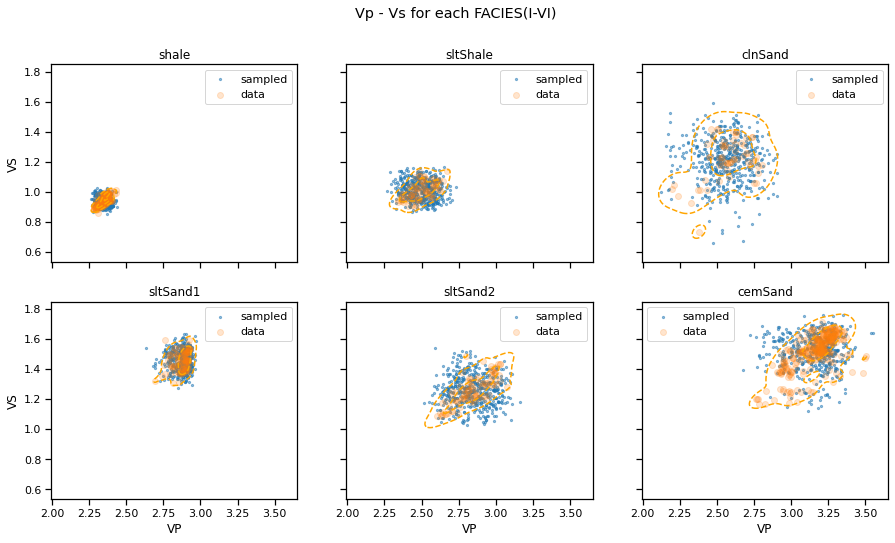

In [6]:
facies = ['shale', 'sltShale', 'clnSand', 'sltSand1', 'sltSand2', 'cemSand']
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,8), sharex=True, sharey=True)
fig.suptitle('Vp - Vs for each FACIES(I-VI)')

# shale
ax1.scatter(vp0, vs0, s=5, label="sampled", alpha=0.5)
ax1.scatter(well2[well2.LABELS==facies_labels[0]]['VP'], well2[well2.LABELS==facies_labels[0]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax1, data=well2[well2.LABELS==facies_labels[0]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax1.set_xlabel("VP"); ax1.set_ylabel("VS")
ax1.set_title(facies[0])

# sltShale
ax2.scatter(vp1, vs1, s=5, label="sampled", alpha=0.5)
ax2.scatter(well2[well2.LABELS==facies_labels[1]]['VP'], well2[well2.LABELS==facies_labels[1]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax2, data=well2[well2.LABELS==facies_labels[1]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax2.set_xlabel("VP"); ax1.set_ylabel("VS")
ax2.set_title(facies[1])

# clnSand
ax3.scatter(vp2, vs2, s=5, label="sampled", alpha=0.5)
ax3.scatter(well2[well2.LABELS==facies_labels[2]]['VP'], well2[well2.LABELS==facies_labels[2]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax3, data=well2[well2.LABELS==facies_labels[2]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax3.set_xlabel("VP"); ax4.set_ylabel("VS")
ax3.set_title(facies[2])

# sltSand1
ax4.scatter(vp3, vs3, s=5, label="sampled", alpha=0.5)
ax4.scatter(well2[well2.LABELS==facies_labels[3]]['VP'], well2[well2.LABELS==facies_labels[3]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax4, data=well2[well2.LABELS==facies_labels[3]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax4.set_xlabel("VP"); ax1.set_ylabel("VS")
ax4.set_title(facies[3])

# sltSand2
ax5.scatter(vp4, vs4, s=5, label="sampled", alpha=0.5)
ax5.scatter(well2[well2.LABELS==facies_labels[4]]['VP'], well2[well2.LABELS==facies_labels[4]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax5, data=well2[well2.LABELS==facies_labels[4]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax5.set_xlabel("VP"); ax1.set_ylabel("VS")
ax5.set_title(facies[4])

# cemSand
ax6.scatter(vp5, vs5, s=5, label="sampled", alpha=0.5)
ax6.scatter(well2[well2.LABELS==facies_labels[5]]['VP'], well2[well2.LABELS==facies_labels[5]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax6, data=well2[well2.LABELS==facies_labels[5]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax6.set_xlabel("VP"); ax4.set_ylabel("VS")
ax6.set_title(facies[5])

#plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()

### Gaussian sampled brine and sampled oil case

### Use sampled brine and transform to oil case

In [7]:

vp1ox, vs1ox, rho1ox, k1ox = xfrm(vp1*1000, vs1*1000, rho1, RHO_BRINE, K_BRINE, RHO_OIL, K_OIL, k01, phie1)  # sltShale
vp2ox, vs2ox, rho2ox, k2ox = xfrm(vp2*1000, vs2*1000, rho2, RHO_BRINE, K_BRINE, RHO_OIL, K_OIL, k02, phie2)  # clnSand
vp3ox, vs3ox, rho3ox, k3ox = xfrm(vp3*1000, vs3*1000, rho3, RHO_BRINE, K_BRINE, RHO_OIL, K_OIL, k01, phie3)  # sltSand1
vp4ox, vs4ox, rho4ox, k4ox = xfrm(vp4*1000, vs4*1000, rho4, RHO_BRINE, K_BRINE, RHO_OIL, K_OIL, k01, phie4)  # sltSand2
vp5ox, vs5ox, rho5ox, k5ox = xfrm(vp5*1000, vs5*1000, rho5, RHO_BRINE, K_BRINE, RHO_OIL, K_OIL, k01, phie5)  # cemSand

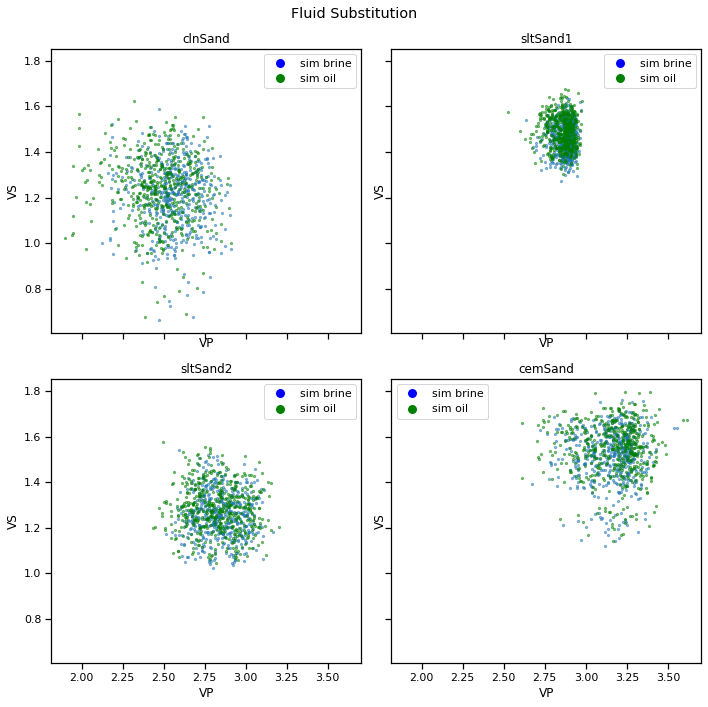

In [8]:
from matplotlib.lines import Line2D

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
fig.suptitle('Fluid Substitution')

custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='sim brine'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='sim oil')]


# ax1.scatter(vp1, vs1, alpha=0.5, s=5, label='simulated brine')
# ax1.scatter(vp1ox/1000, vs1ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
# ax1.set_xlabel("VP"); ax1.set_ylabel("VS"); ax1.set_title(facies[1])

# clnSand
ax1.scatter(vp2, vs2, alpha=0.5, s=5, label='simulated brine')
ax1.scatter(vp2ox/1000, vs2ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
ax1.set_xlabel("VP"); ax1.set_ylabel("VS"); ax1.set_title(facies[2])

# sltSand1
ax2.scatter(vp3, vs3, alpha=0.5, s=5, label='simulated brine')
ax2.scatter(vp3ox/1000, vs3ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
ax2.set_xlabel("VP"); ax2.set_ylabel("VS"); ax2.set_title(facies[3])

# sltSand2
ax3.scatter(vp4, vs4, alpha=0.5, s=5, label='simulated brine')
ax3.scatter(vp4ox/1000, vs4ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
ax3.set_xlabel("VP"); ax3.set_ylabel("VS"); ax3.set_title(facies[4])

# cemSand
ax4.scatter(vp5, vs5, alpha=0.5, s=5, label='simulated brine')
ax4.scatter(vp5ox/1000, vs5ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
ax4.set_xlabel("VP"); ax4.set_ylabel("VS"); ax4.set_title(facies[5])

plt.tight_layout()
for ax in fig.get_axes():
    ax.legend(handles=custom_lines)


# plt.savefig("./images/vp_vs_sim_fl_sub.png")


$$
R(\theta) \approx R(0) + Gsin^2\theta
$$

$R(0) = \frac{1}{2} \bigg(\frac{\Delta V_P}{V_P} + \frac{\Delta \rho}{\rho} \bigg)$

$G = \frac{1}{2} \frac{\Delta V_P}{V_P} - 2 \frac{V_S^2}{V_P^2} \bigg(\frac{\Delta \rho}{\rho} + 2 \frac{\Delta V_S}{V_S} \bigg)$

In [16]:
def r0g_model(vp1, vs1, rho1, vp2, vs2, rho2):
    
    R0 = []
    G = []
    R_theta = []

    for i in range(len(vp1)):

        delta_rho = rho2[i] - rho1[i]
        delta_vp = vp2[i] - vp1[i]
        delta_vs = vs2[i] - vs1[i]

        vp = (vp2[i] + vp1[i]) / 2
        vs = (vs2[i] + vs1[i]) / 2
        rho = (rho2[i] + rho1[i]) / 2

        R0_temp = 1/2*((delta_vp / vp) + (delta_rho / rho))
        R0.append(R0_temp)

        G_temp = 1/2 * (delta_vp / vp) - 2 * vs**2/vp**2 * ((delta_rho / rho) + (2*delta_vs / vs))
        G.append(G_temp)

        R_theta_i = []
        for theta in range(41):
            R_theta_i.append(R0_temp + G_temp*(np.sin(math.radians(theta))**2))
        R_theta.append([R_theta_i])        

    median = []

    for j in range(41):
        angle = []
        for k in range(len(vp2)):
            angle.append(R_theta[k][0][j])
        median.append(statistics.median(angle))
        
    return R0, G, R_theta, median

In [20]:
# shale-shale
# r00, G00, Rtheta00, med00 = r0g(vp0a, vs0a, rho0a, vp0b, vs0b, rho0b)  #  need two different samples, hence vp0a, vp0b, etc

# shale-sltShale
r01_b, G1_b, Rtheta1_b, med1_b = r0g(vp0, vs0, rho0, vp1, vs1, rho1)
# r01_o, G1_o, Rtheta1_o, med1_o = r0g_model(vp0, vs0, rho0, vp1ox/1000, vs1ox/1000, rho1ox)

# shale-clnSand
r02_b, G2_b, Rtheta2_b, med2_b = r0g(vp0, vs0, rho0, vp2, vs2, rho2)
r02_o, G2_o, Rtheta2_o, med2_o = r0g(vp0, vs0, rho0, vp2ox/1000, vs2ox/1000, rho2ox)

# shale-sltSand1
r03_b, G3_b, Rtheta3_b, med3_b = r0g(vp0, vs0, rho0, vp3, vs3, rho3)
r03_o, G3_o, Rtheta3_o, med3_o = r0g(vp0, vs0, rho0, vp3ox/1000, vs3ox/1000, rho3ox)

# shale-sltSand2
r04_b, G4_b, Rtheta4_b, med4_b = r0g(vp0, vs0, rho0, vp4, vs4, rho4)
r04_o, G4_o, Rtheta4_o, med4_o = r0g(vp0, vs0, rho0, vp4ox/1000, vs4ox/1000, rho4ox)

# shale-cemSand
r05_b, G5_b, Rtheta5_b, med5_b = r0g(vp0, vs0, rho0, vp5, vs5, rho5)
r05_o, G5_o, Rtheta5_o, med5_o = r0g(vp0, vs0, rho0, vp5ox/1000, vs5ox/1000, rho5ox)

In [22]:
# facies = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]

# take two samples of shale to plot against itself
kde_3d_layer0_resample = kde_3d_layer0.resample(500)  # shale
vp0a, vs0a, rho0a = kde_3d_layer0_resample  # shale
kde_3d_layer0_resample = kde_3d_layer0.resample(500)  # shale
vp0b, vs0b, rho0b = kde_3d_layer0_resample  # shale

# shale-shale
# r00, G00, Rtheta00, med00 = r0g_model(vp0, vs0, rho0, vp0, vs0, rho0)
r00, G00, Rtheta00, med00 = r0g_model(vp0a, vs0a, rho0a, vp0b, vs0b, rho0b)

# shale-sltShale
r01_b, G1_b, Rtheta1_b, med1_b = r0g_model(vp0, vs0, rho0, vp1, vs1, rho1)
# r01_o, G1_o, Rtheta1_o, med1_o = r0g_model(vp0, vs0, rho0, vp1ox/1000, vs1ox/1000, rho1ox)

# shale-clnSand
r02_b, G2_b, Rtheta2_b, med2_b = r0g_model(vp0, vs0, rho0, vp2, vs2, rho2)
r02_o, G2_o, Rtheta2_o, med2_o = r0g_model(vp0, vs0, rho0, vp2ox/1000, vs2ox/1000, rho2ox)

# shale-sltSand1
r03_b, G3_b, Rtheta3_b, med3_b = r0g_model(vp0, vs0, rho0, vp3, vs3, rho3)
r03_o, G3_o, Rtheta3_o, med3_o = r0g_model(vp0, vs0, rho0, vp3ox/1000, vs3ox/1000, rho3ox)

# shale-sltSand2
r04_b, G4_b, Rtheta4_b, med4_b = r0g_model(vp0, vs0, rho0, vp4, vs4, rho4)
r04_o, G4_o, Rtheta4_o, med4_o = r0g_model(vp0, vs0, rho0, vp4ox/1000, vs4ox/1000, rho4ox)

# shale-cemSand
r05_b, G5_b, Rtheta5_b, med5_b = r0g_model(vp0, vs0, rho0, vp5, vs5, rho5)
r05_o, G5_o, Rtheta5_o, med5_o = r0g_model(vp0, vs0, rho0, vp5ox/1000, vs5ox/1000, rho5ox)

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

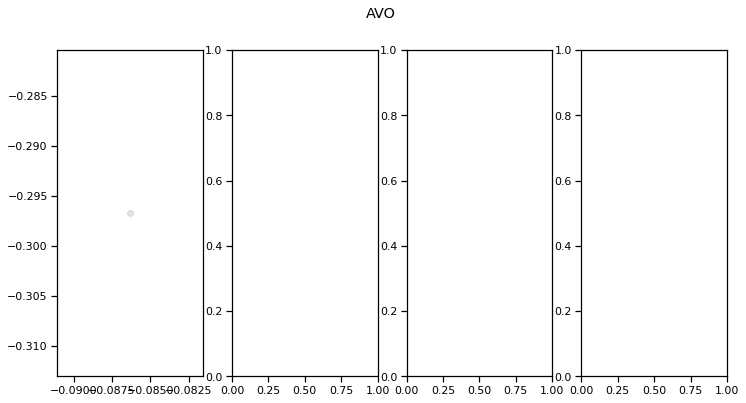

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,6))
fig.suptitle('AVO')

ax1.scatter(r02_b, G2_b, label="shale-clnSand (brine)", alpha=0.1, color='k')  # ? Facies IIa
sns.kdeplot(ax=ax1, x=r02_b, y=G2_b, color="k", linestyles="-")
ax1.set_xlabel("R(0)"); ax1.set_ylabel("G")
ax1.set_xlim(-0.25, 0.15); ax1.set_ylim(-0.85, 0.25)

for i in range(len(vp2)):
    ax2.plot(Rtheta2_b[i][0], alpha=0.02, color='k')
ax2.plot(med2_b)
ax2.set_xlabel("theta"); ax2.set_ylabel("Amplitude")
ax2.set_ylim(-0.45, 0.15)

ax3.scatter(r02_o, G2_o, label="shale-clnSand (oil)", alpha=0.1, color='k')  # ? Facies IIa
sns.kdeplot(ax=ax3, x=r02_o, y=G2_o, color="k", linestyles="-")
ax3.set_xlabel("R(0)"); ax3.set_ylabel("G")
ax3.set_xlim(-0.25, 0.15); ax3.set_ylim(-0.85, 0.25)

for i in range(len(vp2)):
    ax4.plot(Rtheta2_o[i][0], alpha=0.02, color='k')
ax4.plot(med2_o)
ax4.set_xlabel("theta"); ax4.set_ylabel("Amplitude")
ax4.set_ylim(-0.45, 0.15)

for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()
    ax.axhline(0, color='gray')
    ax.axvline(0, color='gray')
    
plt.tight_layout()

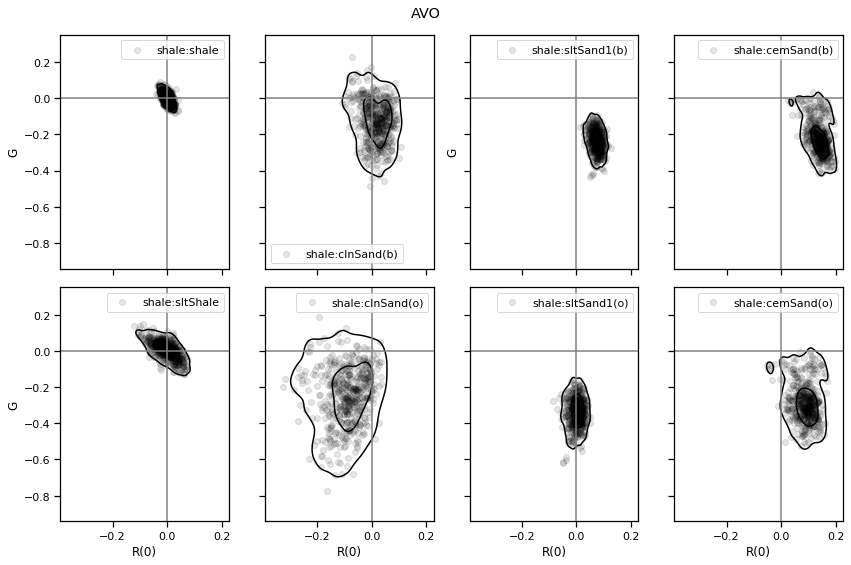

In [19]:
# shale-shale:            r00,   G00,  Rtheta00,  med00 =  r0g_model(vp0, vs0, rho0, vp0, vs0, rho0)
# shale-sltShale:         r01_b, G1_b, Rtheta1_b, med1_b = r0g_model(vp0, vs0, rho0, vp1, vs1, rho1)
# shale-clnSand (brine):  r02_b, G2_b, Rtheta2_b, med2_b = r0g_model(vp0, vs0, rho0, vp2, vs2, rho2)
# shale-clnSand (oil):    r02_o, G2_o, Rtheta2_o, med2_o = r0g_model(vp0, vs0, rho0, vp2ox/1000, vs2ox/1000, rho2ox)
# shale-sltSand1 (brine): r03_b, G3_b, Rtheta3_b, med3_b = r0g_model(vp0, vs0, rho0, vp3, vs3, rho3)
# shale-sltSand1 (oil):   r03_o, G3_o, Rtheta3_o, med3_o = r0g_model(vp0, vs0, rho0, vp3ox/1000, vs3ox/1000, rho3ox)
# shale-cemSand (brine):  r05_b, G5_b, Rtheta5_b, med5_b = r0g_model(vp0, vs0, rho0, vp5, vs5, rho5)
# shale-cemSand (oil):    r05_o, G5_o, Rtheta5_o, med5_o = r0g_model(vp0, vs0, rho0, vp5ox/1000, vs5ox/1000, rho5ox)

fig, ((ax1, ax2, ax3, ax4),( ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle('AVO')

# shale:shale
ax1.scatter(r00, G00, label="shale:shale", alpha=0.1, color='k')
sns.kdeplot(ax=ax1, x=r00, y=G00, color="k", linestyles="-", levels=3)
ax1.set_xlabel("R(0)"); ax1.set_ylabel("G")

# shale:sltShale
ax5.scatter(r01_b, G1_b, label="shale:sltShale", alpha=0.1, color='k')
sns.kdeplot(ax=ax5, x=r01_b, y=G1_b, color="k", linestyles="-", levels=3)
ax5.set_xlabel("R(0)"); ax5.set_ylabel("G")

# shale:clnSand (brine)
ax2.scatter(r02_b, G2_b, label="shale:clnSand(b)", alpha=0.1, color='k')
sns.kdeplot(ax=ax2, x=r02_b, y=G2_b, color="k", linestyles="-", levels=3)
ax2.set_xlabel("R(0)"); ax3.set_ylabel("G")

# shale:clnSand (oil)
ax6.scatter(r02_o, G2_o, label="shale:clnSand(o)", alpha=0.1, color='k')
sns.kdeplot(ax=ax6, x=r02_o, y=G2_o, color="k", linestyles="-", levels=3)
ax6.set_xlabel("R(0)"); ax6.set_ylabel("G")

# shale:sltSand1 (brine)
ax3.scatter(r03_b, G3_b, label="shale:sltSand1(b)", alpha=0.1, color='k')
sns.kdeplot(ax=ax3, x=r03_b, y=G3_b, color="k", linestyles="-", levels=3)
ax3.set_xlabel("R(0)"); ax3.set_ylabel("G")

# shale:sltSand1 (oil)
ax7.scatter(r03_o, G3_o, label="shale:sltSand1(o)", alpha=0.1, color='k')
sns.kdeplot(ax=ax7, x=r03_o, y=G3_o, color="k", linestyles="-", levels=3)
ax7.set_xlabel("R(0)"); ax7.set_ylabel("G")

# shale:cemSand (brine)
ax4.scatter(r05_b, G5_b, label="shale:cemSand(b)", alpha=0.1, color='k')
sns.kdeplot(ax=ax4, x=r05_b, y=G5_b, color="k", linestyles="-", levels=3)
ax4.set_xlabel("R(0)"); ax4.set_ylabel("G")

# shale:cemSand (oil)
ax8.scatter(r05_o, G5_o, label="shale:cemSand(o)", alpha=0.1, color='k')
sns.kdeplot(ax=ax8, x=r05_o, y=G5_o, color="k", linestyles="-", levels=3)
ax8.set_xlabel("R(0)"); ax8.set_ylabel("G")

# ax4.scatter(r04_b, G4_b, label="Facies IV - brine", alpha=0.1, color='k')
# sns.kdeplot(ax=ax4, x=r04_b, y=G4_b, color="k", linestyles="-", levels=3)
# ax3.set_xlabel("R(0)"); ax3.set_ylabel("G")

# ax9.scatter(r04_o, G4_o, label="Facies IV - oil", alpha=0.1, color='k')
# sns.kdeplot(ax=ax9, x=r04_o, y=G4_o, color="k", linestyles="-", levels=3)
# ax9.set_xlabel("R(0)"); ax3.set_ylabel("G")

for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()
    
    ax.axvline(0, color='gray')
    ax.axhline(0, color='gray')
    
plt.tight_layout()

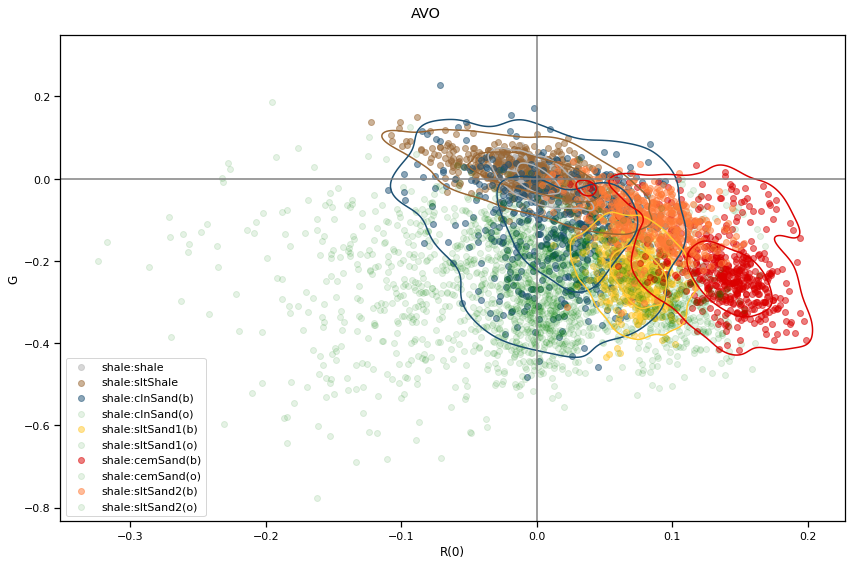

In [23]:
#
ccc = ['#B3B3B3', '#996633', '#1B4F72', '#FFC82E','#FF7A36', '#DB0000', '#40CBFF']

fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle('AVO')

# shale:shale
ax.scatter(r00, G00, label="shale:shale", alpha=0.5, color=ccc[0])

# shale:sltShale
ax.scatter(r01_b, G1_b, label="shale:sltShale", alpha=0.5, color=ccc[1])

# shale:clnSand (brine)
ax.scatter(r02_b, G2_b, label="shale:clnSand(b)", alpha=0.5, color=ccc[2])

# shale:clnSand (oil)
ax.scatter(r02_o, G2_o, label="shale:clnSand(o)", alpha=0.1, color='g')

# shale:sltSand1 (brine)
ax.scatter(r03_b, G3_b, label="shale:sltSand1(b)", alpha=0.5, color=ccc[3])

# shale:sltSand1 (oil)
ax.scatter(r03_o, G3_o, label="shale:sltSand1(o)", alpha=0.1, color='g')

# shale:cemSand (brine)
ax.scatter(r05_b, G5_b, label="shale:cemSand(b)", alpha=0.5, color=ccc[5])

# shale:cemSand (oil)
ax.scatter(r05_o, G5_o, label="shale:cemSand(o)", alpha=0.1, color='g')

# shale:sltSand2 (brine)
ax.scatter(r04_b, G4_b, label="shale:sltSand2(b)", alpha=0.5, color=ccc[4])

# shale:sltSand2 (oil)
ax.scatter(r04_o, G4_o, label="shale:sltSand2(o)", alpha=0.1, color='g')

# shale:shale
sns.kdeplot(ax=ax, x=r00, y=G00, color=ccc[0], linestyles="-", levels=3)
# shale:sltShale
sns.kdeplot(ax=ax, x=r01_b, y=G1_b, color=ccc[1], linestyles="-", levels=3)
# shale:clnSand (brine)
sns.kdeplot(ax=ax, x=r02_b, y=G2_b, color=ccc[2], linestyles="-", levels=3)
# shale:clnSand (oil)
#sns.kdeplot(ax=ax, x=r02_o, y=G2_o, color="g", linestyles="-", levels=3)
# shale:sltSand1 (brine)
sns.kdeplot(ax=ax, x=r03_b, y=G3_b, color=ccc[3], linestyles="-", levels=3)
# shale:sltSand1 (oil)
#sns.kdeplot(ax=ax, x=r03_o, y=G3_o, color="g", linestyles="-", levels=3)
# shale:cemSand (brine)
sns.kdeplot(ax=ax, x=r05_b, y=G5_b, color=ccc[5], linestyles="-", levels=3)
# shale:cemSand (oil)
#sns.kdeplot(ax=ax, x=r05_o, y=G5_o, color="g", linestyles="-", levels=3)
#sns.kdeplot(ax=ax, x=r04_b, y=G4_b, color=ccc[4], linestyles="-", levels=3)
#sns.kdeplot(ax=ax, x=r04_o, y=G4_o, color="g", linestyles="-", levels=3)


ax.set_xlabel("R(0)"); ax.set_ylabel("G")
ax.axvline(0, color='gray')
ax.axhline(0, color='gray')
ax.legend()
    
plt.tight_layout()






In [15]:
#!pip install kalepy

In [16]:
%reload_ext autoreload
%autoreload 2
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 12})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.rc('figure', figsize=[8, 4])
plt.rc('axes', grid=True)
plt.rcParams.update({'grid.alpha': 0.25})

import kalepy as kale

reload(kale.kde)
reload(kale.kernels)
reload(kale.utils)
reload(kale.plot)
reload(kale)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from kalepy.plot import nbshow



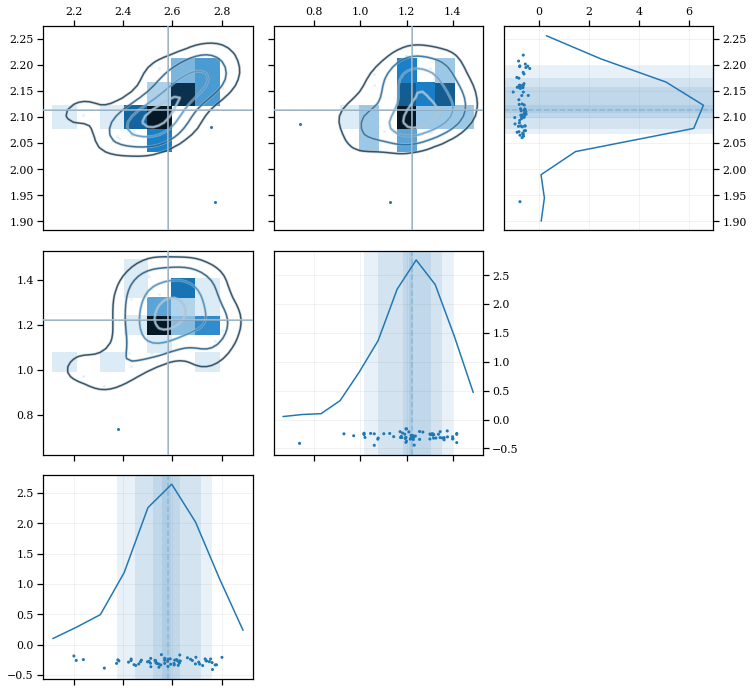

In [17]:
kde = kale.KDE(vp2_vs2_rho2)
kale.corner(kde)

nbshow()

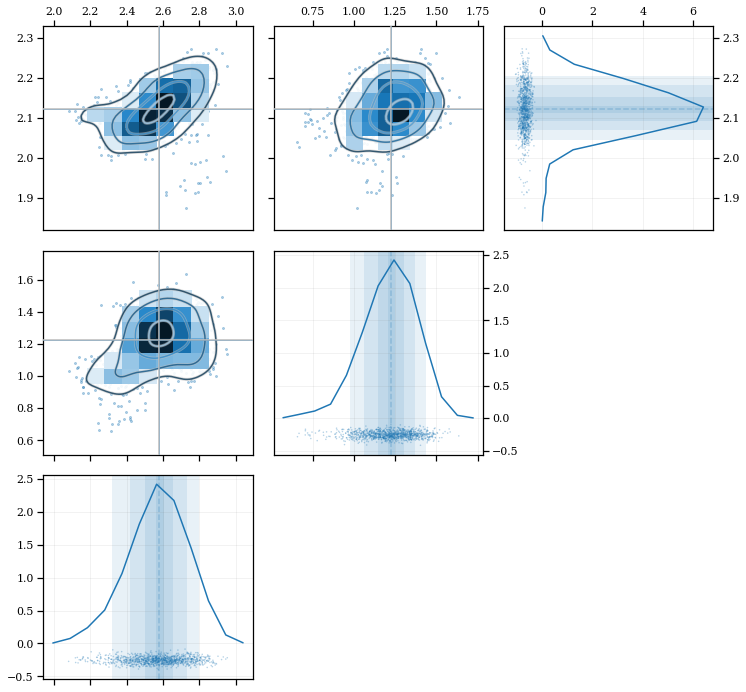

In [18]:
samples_1000 = kde.resample(1000)
#print(len(samples[0]))
kale.corner(samples_1000)
nbshow()